<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Logistic Regression on MNIST</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Marc de Kamps and University of Leeds</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## Logistic Regression on MNIST

### Introduction

This notebook is for exploration. It contains code snippets that you can reuse elsewhere. In particular it
- Demonstrates how to obtain the MNIST dataset
- Uses a PyTorch frontend for the MNIST dataset that allows easy access to each image and its classification
- It demonstrates steepest gradient descent for the multiclass cross entropy loss function (something we will re-examine using PyTorch as a framework.

This notebook is used in preparation for Activity 2.4.


## MNIST data

This is a first exploration of the MNIST dataset, which consists of a large collection of handwritten numerals, i.e images. The images are grey-scale $28 \times 28$ pixels, and each image is associated with a label, which
can take on any of the ten values, '0', '1', ..., '9', representing a human judgement about which numeral the image
is supposed to represent.

### Warning
The first two lines in the following code are a hack after the disappearance of the original dataset website. It is a temporary fix. If you find the code block below doesn't work, contact the module leader. It will not be a major problem.

In [1]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

import torch
from torchvision import datasets, transforms

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('.', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('.', train=False,
                       transform=transform)

--2023-11-23 14:20:07--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-11-23 14:20:07--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [              <=>   ]  33.20M  1.08MB/s    in 25s     

2023-11-23 14:20:32 (1.32 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-idx3-u

The code does nothing but download the dataset and then transform it into a Pytorch native format, which is a Tensor. For practical purposes you can treat Tensor's as Numpy arrays for now. With that in mind, it is easy to inspect the dataset.

In [2]:
print(dataset1[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Careful inspection of the output of the print statement shows this is a (1,2) tensor, that is a single row of two elements. Let us first consider the second element:

In [3]:
print(dataset1[0][1])

5


This is a single numeral. Possibly the label of the image, which then would be the first element. Let's explore this hypothesis.

In [4]:
import matplotlib.pyplot as plt
# in general you have to be careful in convering tensors to python arrays
# a tensor in general will be created on the gpu, and will have some stuff that doesn't relate to the data, like
# gradient information. First convert it to a cpu object, detach the data and then convert it to numpy arrays.
np_arr = dataset1[0][0].to('cpu').detach().numpy()
print(np_arr.shape)

(1, 28, 28)


It is tempting to try and run imshow directly on np_arr. It won't work and the shape information should give you a clue as to why not.

In [5]:
print(np_arr[0].shape)
nr_pix =np_arr[0].shape[0]

(28, 28)


That should be better.

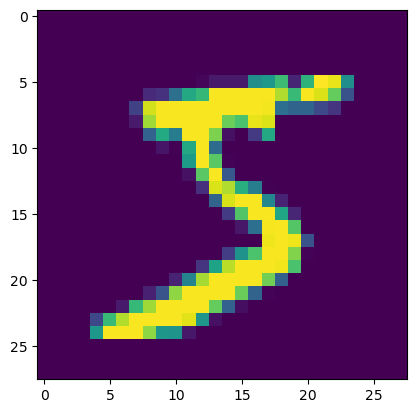

In [6]:
plt.imshow(np_arr[0])

That's better! Do the image and label match? Let's try a random other pattern.

In [7]:
print(dataset1[122][1])

2


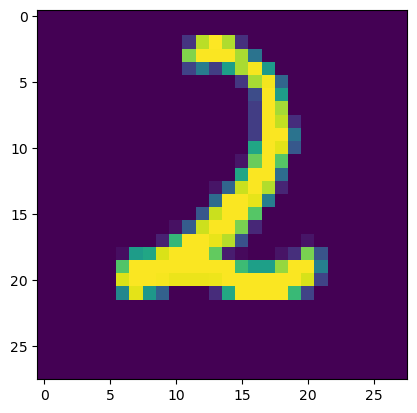

In [8]:
plt.imshow(dataset1[122][0][0])
plt.savefig('two.png')

In [9]:
import numpy as np

design=np.array([t[0].to('cpu').detach().numpy().flatten() for t in dataset1])
labels=[t[1] for t in dataset1]

In [10]:
print(design.shape)

(60000, 784)


Are the rows indeed images?

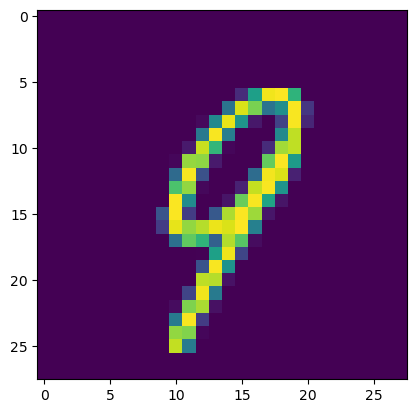

In [11]:
img22 = np.array(design[22]) # copy it
img22.shape = nr_pix, nr_pix
plt.imshow(img22)

Looks that way, so *design* is a design matrix.

Convert the labels into target vectors:

In [12]:
nr_classes = 10
t=np.zeros(design.shape[0]*nr_classes)
t.shape=design.shape[0],nr_classes

for i,ind in enumerate(labels):
    t[i][ind] = 1.

### Create the actual regressor

In [13]:
# add a constant one to each pattern
ones = np.ones(design.shape[0])
ones.shape = design.shape[0],1
designbias=np.concatenate((design,ones),axis=1)
print(designbias.shape)

(60000, 785)


In [14]:
# create the weights. A given image connects to 785 of a single node. There will be 10 nodes, one

weights = np.random.normal(0.,1.,size=(nr_pix*nr_pix+1)*nr_classes)
weights.shape = nr_pix*nr_pix + 1, nr_classes



The main text mentions a numerical issue that may crop up when implementing a naive implementation of softmax. Have a look at the stackoverflow discussion.

The gradient is given in the main text by the following equation:
$$
\frac{\partial E}{\partial w_j} = \sum^N_{i=1}(y_{ij} - t_{ij}) \boldsymbol{\Phi}_i
$$
As you can see, with the help of *np.outer*, this line can be expressed very tersely in Python.

In [15]:
# A suitable softmax implementation was taken from this discussion:
# https://stackoverflow.com/questions/42599498/numercially-stable-softmax
# (sic)



def stableSoftmax(x):
    z = x - np.max(x, axis=-1, keepdims=True)
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    softmax = numerator / denominator
    return softmax

def update(designbias,weights):
    return stableSoftmax(designbias.dot(weights))

# The gradient is calculated over a single input pattern. This is a 10 \time 785 matrix. To do this
# over the entire dataset would require 60000 of them, which may lead to memory problems

def gradient(target, weights, designbias,i):
    ms=np.outer(designbias[i],update(designbias,weights)[i] - target[i])
    return ms
    

### Evaluating our Regressor

Before we do any training, let's evaluate the regressor on the test set.

In [16]:
designtest=np.array([t[0].to('cpu').detach().numpy().flatten() for t in dataset2])
labelstest=np.array([t[1] for t in dataset2])
print(labelstest.shape)
ones = np.ones(designtest.shape[0])
ones.shape = designtest.shape[0],1
designbiastest=np.concatenate((designtest,ones),axis=1)

def correctlyClassified(labels,designbias,weights):
    outcomes=update(designbias,weights)
    outcomelabels = np.array([ np.argmax(x) for x in outcomes ])
    difftest = outcomelabels - labels
    return np.count_nonzero(difftest==0),outcomes.shape[0]

correctlyClassified(labelstest,designbiastest,weights)

(10000,)


(911, 10000)

We use a very crude measure: we count how many patterns were actually classified in agreement with their label. As you can see the results are approximately at chance level, as they should be.

In [17]:
nrdatapoints=designbias.shape[0]
r = 0.02
for i in range(5000):
    if i%1000 == 0: print(i)
        
    weights -= r*gradient(t, weights, designbias,np.random.randint(0,nrdatapoints-1))

0
1000
2000
3000
4000


In [18]:
correctlyClassified(labelstest,designbiastest,weights)

(8018, 10000)

After training things have considerably improved.  A proper analysis should be done with separation of test and training set and cross validation (see Machine Learning pipeline notebooks).